# DFUC24 Baseline: GroundingDINO + SAM for ulcer object detection and semantic segmentation on DFUC22 test dataset

The author of this notebook is Benjamin Bracke ([Github](https://github.com/B-Bracke)).

## Imports

In [36]:
import os
import glob
import json
import copy
from tqdm import tqdm
import numpy as np
import pandas as pd
import cv2
import albumentations as A
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch import autocast

#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TOKENIZERS_PARALLELISM"] = "1"

## Defining important path variables

In [ ]:
ROOT_DIR = os.path.abspath(os.getcwd()) # current path of the notebook
DATA_DIR = "/raid/DFUC24/datasets/dfuc2022/original/test/" # path to the dataset root directory
IMAGE_FILES = os.path.join(DATA_DIR, "images/") # path to the images

print("Directories:")
print("Root directory:", ROOT_DIR)
print("Image files in directory:", IMAGE_FILES)

## Data set

### Define the dataset class, pre-processing and augmentation pipelines and helper functions

In [ ]:
class DFUC2022_ODTestDataset(Dataset):
    def __init__(self, image_files:list):
        self.image_files = image_files # list of image filenames

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        img_file = self.image_files[index]
        
        # load image and mask files as numpy array using opencv
        img = cv2.cvtColor(cv2.imread(img_file, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

        # rotate image if upright
        if img.shape[0] > img.shape[1]:
            img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
            rotate = True
        else:
            rotate = False

        img = np.rollaxis(img, -1, 0)
        
        img = torch.from_numpy(img).to(torch.uint8)
        size = torch.tensor(img.shape[:2])
        return (img, size, rotate, os.path.basename(img_file)) # return the image, the size of the image, the rotation status and the filename


def move_to_device(batch, device):
    """
    Move a batch of tensors (list of dictionaries) to the specified device.
    
    Args:
    - batch (list of dict): A list of dictionaries containing tensors.
    - device (torch.device): The target device to move the tensors to.
    
    Returns:
    - list of dict: A list of dictionaries with tensors moved to the specified device.
    """
    return [{key: value.to(device) if torch.is_tensor(value) else value for key, value in sample.items()} for sample in batch]


def class_label2label(boxes):
    """
    Rename the key 'class_labels' to 'labels' in each dictionary

    Args:
    boxes (list of dict): List of dictionaries, each containing a key "class_labels".
    """
    converted_boxes = copy.deepcopy(boxes)
    for box_dict in converted_boxes:
        box_dict['labels'] = box_dict.pop('class_labels')
    return converted_boxes

def convert_bbox_format2sam_prompts(data, image_width, image_height):
    result = []
    max_boxes = 0
    
    # First pass to find the maximum number of boxes
    for item in data:
        boxes_tensor = item['boxes']
        num_boxes = boxes_tensor.shape[0] if boxes_tensor.numel() > 0 else 0
        max_boxes = max(max_boxes, num_boxes)
    
    # Second pass to convert and pad boxes
    for item in data:
        boxes_tensor = item['boxes']
        if boxes_tensor.numel() == 0:
            boxes_list = []
        else:
            # Convert from image size normalized xyxy to non-normalized xyxy format
            boxes = boxes_tensor.cpu().tolist()
            converted_boxes = []
            for box in boxes:
                x1 = box[0] * image_width
                y1 = box[1] * image_height
                x2 = box[2] * image_width
                y2 = box[3] * image_height
                converted_boxes.append([x1, y1, x2, y2])
            
            boxes_list = converted_boxes
        
        # Pad the boxes_list if it has fewer than max_boxes elements
        while len(boxes_list) < max_boxes:
            boxes_list.append([0, 0, 0, 0])

        result.append(boxes_list)
    
    return result


id2label = {
    0: "background.",
    1: "wound."}
print(f"label classes {id2label}")

### Initializing the test data set and data loader

In [ ]:
test_image_files = sorted(glob.glob(IMAGE_FILES + '*.jpg')) # list of image files

# create validation datasets
test_dataset = DFUC2022_ODTestDataset(test_image_files)
print(f'Found {len(test_dataset)} images for testing')

# create valid data loaders
BATCH_SIZE = 8 # batch size per forward pass
TEXT_PROMPT = ["wound ."] # text prompt for the grounding dino model for object detection

# validation data loader
test_loader = DataLoader(dataset=test_dataset,
                          shuffle=False, 
                          batch_size=BATCH_SIZE, 
                          num_workers=4, # for multi-threading processing
                          pin_memory=True)

### Display some images

In [41]:
dataiter = iter(test_loader) # get iterator of test data loader 

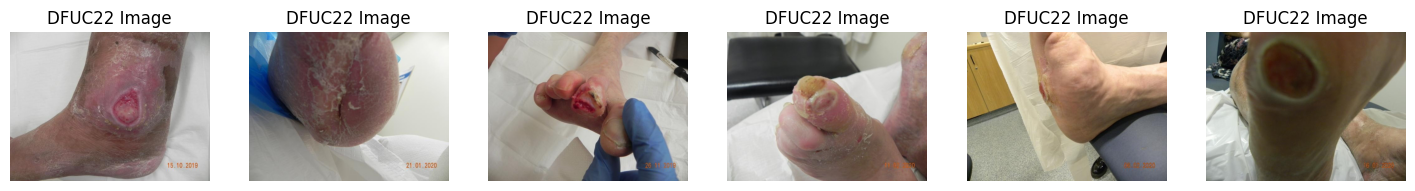

In [42]:
def show_subset(images, n):
    images = images.numpy() 
    
    fig, ax = plt.subplots(1, n, figsize=(n*3,4))
    for i in range(n):
        ax[i].imshow(np.rollaxis(images[i,:,:,:],0,3), vmin=0, vmax=1, cmap='gray') # np.rollaxis(images[i,:,:,:],0,3)) to swap channel axes to channels last
        ax[i].set_title('DFUC22 Image')
        ax[i].axis('off')
    plt.show()

images, sizes, rotated, files = next(dataiter) # get a random batch of test iterator
show_subset(images, n=6) # show images, masks subset of size n of batch

## Defining the models

In [43]:
device = ("cuda" if torch.cuda.is_available() else "cpu") 
print(f"device: {device}")

device: cuda


### GroundedDINO Model

In [ ]:
from transformers import GroundingDinoProcessor, GroundingDinoForObjectDetection

# load grounding dino model for object detection
gd_model_id = "IDEA-Research/grounding-dino-base"
gd_model = GroundingDinoForObjectDetection.from_pretrained(gd_model_id, return_dict=True).to(device)
gd_processor = GroundingDinoProcessor.from_pretrained(gd_model_id)

# load checkpoint if available
GD_CHECKPOINTS = None # vanilla model
#GD_CHECKPOINTS = "./models/groundingdino_finetune/model_epoch53.pth" # finetuned model

if GD_CHECKPOINTS:
    gd_model.load_state_dict(torch.load(f'{GD_CHECKPOINTS}', map_location='cpu'))
    torch.cuda.empty_cache()
    print(f"use model checkpoints: {GD_CHECKPOINTS}")

print(gd_model)

### SAM Model

In [ ]:
from transformers import SamProcessor, SamModel

# load sam model
sam_model_id = "facebook/sam-vit-huge"
sam_model = SamModel.from_pretrained(sam_model_id, return_dict=True).to(device)
sam_processor = SamProcessor.from_pretrained(sam_model_id)

# load checkpoint if available
SAM_CHECKPOINTS = None # vanilla model
#SAM_CHECKPOINTS = "./models/sam_finetune/model_epoch29.pth" # finetuned model

if SAM_CHECKPOINTS:
    sam_model.load_state_dict(torch.load(f'{SAM_CHECKPOINTS}', map_location='cpu'))
    torch.cuda.empty_cache()
    print(f"use model checkpoints: {SAM_CHECKPOINTS}")

print(sam_model)

## Get predictions for the test dataset

In [ ]:
SAVE_PATH = "./models/GroundingDino + SAM/GD_SAM (vanilla)"
#SAVE_DIR = "./models/GroundingDino + SAM/GD_SAMfinetune (GD vanilla, SAM fine-tuned)"
#SAVE_DIR = "./models/GroundingDino + SAM/GDfinetune_SAM (GD fine-tuned, SAM vanilla)"
#SAVE_DIR = "./models/GroundingDino + SAM/GDfinetune_SAMfinetune (GD fine-tuned, SAM fine-tuned)"

os.makedirs(SAVE_PATH, exist_ok=True) # Make sure the save directory exists


with torch.no_grad():
    # put models in evaluation mode
    gd_model.eval()
    sam_model.eval()

    # iterate over the test dataset, get predictions of groundeddino for object detection and use it as prompts for sam model for semantic segmentation and then save the masks as individual image files
    for batch_idx, (images, sizes, rotated, files) in enumerate(tqdm(test_loader)):
        prompts = TEXT_PROMPT * images.shape[0] # repeat the text prompt for each image in the batch

        # forward GroundedDINO to get object detection predictions
        gd_inputs = gd_processor(images=images, text=prompts, return_tensors="pt").to(device)
        with autocast(device_type='cuda', dtype=torch.float16):
            gd_outputs = gd_model(**gd_inputs, return_dict=True)
        gd_preds = gd_processor.image_processor.post_process_object_detection(gd_outputs, threshold=0.3)
        
        # forward SAM model to get semantic segmentation predictions
        sam_prompts = convert_bbox_format2sam_prompts(gd_preds, image_width=images.shape[3], image_height=images.shape[2]) # convert groundeddino predictions to sam prompts
        sam_inputs = sam_processor(images=images, input_boxes=sam_prompts, return_tensors="pt").to(device)

        with autocast(device_type='cuda', dtype=torch.float16):
            sam_outputs = sam_model(**sam_inputs, return_dict=True, multimask_output=False)

        sam_preds = sam_processor.post_process_masks(masks=sam_outputs.pred_masks,original_sizes=sam_inputs.original_sizes,reshaped_input_sizes=sam_inputs.reshaped_input_sizes,binarize=False)
        sam_preds = torch.stack([torch.max(mask, dim=0).values.squeeze() for mask in sam_preds], dim=0)  # combine multiple masks to single mask
        sam_preds = (sam_preds.sigmoid() > 0.5).int() # binarize the mask

        # Save prediction masks as individual image files
        for idx in range(sam_preds.size(0)):
            mask = sam_preds[idx].cpu().numpy().astype(np.uint8) * 255  # Convert to uint8 with scale to [0, 255]

            # Rotate the mask back to the original orientation if it was rotated (upside) before 
            if rotated[idx]:
                mask = cv2.rotate(mask, cv2.ROTATE_90_COUNTERCLOCKWISE)
                        
            base_filename = files[idx].split(".")[0] # Get the base filename for the current image without the extension
            save_path = os.path.join(SAVE_PATH, f"{base_filename}.png")  # Construct the save path
            cv2.imwrite(save_path, mask) # Save the mask image


### Make a zip file of the predicted masks ready for submission to the DFUC2022 challenge

In [ ]:
import shutil
shutil.make_archive(os.path.join(SAVE_PATH), 'zip', SAVE_PATH)

### Show some predictions examples 

In [51]:
def show_preds(images, results, pred_masks, n):
    fig, ax = plt.subplots(2, n, figsize=(n*4, 5))
    for i in range(n):
        img = images[i].numpy()
        img = np.rollaxis(img, 0, 3) 
        pred_bboxes = results[i]['boxes'].detach().numpy()
        pred_labels = results[i]['scores'].detach().numpy()

        ax[0, i].imshow(img, vmin=0, vmax=1)
        ax[1, i].imshow(pred_masks[i], vmin=0, vmax=1, cmap='Blues_r')   

        for pred_bbox, pred_label in zip(pred_bboxes, pred_labels):
            x_min, y_min, x_max, y_max = pred_bbox[0] * img.shape[1], pred_bbox[1] * img.shape[0], pred_bbox[2] * img.shape[1], pred_bbox[3] * img.shape[0]
            rect2 = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 linewidth=2, edgecolor='blue', facecolor='none')
            ax[0, i].add_patch(rect2)
            ax[0, i].text(x_min, y_min, f"{(pred_label*100):.1f}", color='white', fontsize=8,
                       bbox=dict(facecolor='blue', alpha=0.5))

        ax[0, i].set_title('GroundedDINO OD pred. (blue)')
        ax[1, i].set_title('SAM pred.')
        ax[0, i].axis('off')
        ax[1, i].axis('off')

    plt.show()      


dataiter = iter(test_loader) # get iterator of valid data loader 

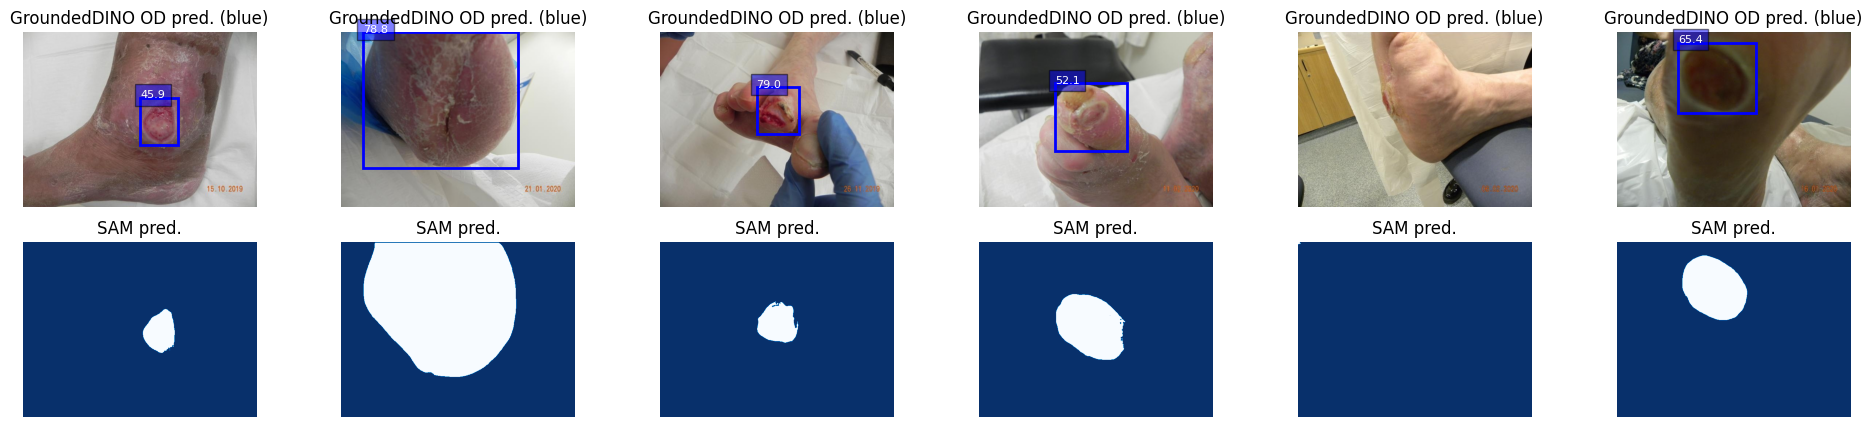

In [52]:
images, sizes, rotated, files = next(dataiter) # get a random batch of train_loader iterator
prompts = TEXT_PROMPT * images.shape[0]

with torch.no_grad():
    gd_model.eval()
    sam_model.eval()

    # forward GroundedDINO to get object detection predictions
    gd_inputs = gd_processor(images=images, text=prompts, return_tensors="pt").to(device)
    
    with autocast(device_type='cuda', dtype=torch.float16):
        gd_outputs = gd_model(**gd_inputs, labels=move_to_device(targets, device), return_dict=True)
    
    gd_results = gd_processor.image_processor.post_process_object_detection(gd_outputs, threshold=0.3)

    # forward SAM to get segmentations
    sam_prompts = convert_bbox_format2sam_prompts(gd_results, image_width=images.shape[3], image_height=images.shape[2])
    sam_inputs = sam_processor(images=images, input_boxes=sam_prompts, return_tensors="pt").to(device)
    with autocast(device_type='cuda', dtype=torch.float16):
        sam_outputs = sam_model(**sam_inputs, return_dict=True, multimask_output=False)

    sam_preds = sam_processor.post_process_masks(masks=sam_outputs.pred_masks,original_sizes=sam_inputs.original_sizes,reshaped_input_sizes=sam_inputs.reshaped_input_sizes,binarize=False)
    sam_preds = torch.stack([torch.max(mask, dim=0).values.squeeze() for mask in sam_preds], dim=0) # combine multiple masks to single mask
    sam_preds = (sam_preds.sigmoid() > 0.5).int() # binarize the mask
 
show_preds(images, move_to_device(gd_results, "cpu"), sam_preds.cpu().numpy(), n=6) # show images, masks subset of size n of batch